# Video Odometry

Kevin J. Walchko

Created: 15 Jan 2018

---

I grabbed the test video with my iPhone which saves it in `.mov` format. To convert it to a more portable `.mp4` that OpenCV can easily read, I used `ffmpeg` to convert it.

    ffmpeg -i vo.mov vo.mp4

The true movement of the camera was in an arc across the floor with it canted forward ~30 degrees.

REAR CAMERA

- Resolution: 12MP
- Sensor: Sony Exmor RS (1.22 $\mu$m, 1/3")
- Focal Length: 28mm
- Max Aperture: f/1.8

## References

- [FAST Algorithm for Corner Detection](https://docs.opencv.org/3.4.0/df/d0c/tutorial_py_fast.html)
- [iPhone 7 specs](https://www.apple.com/iphone-7/specs/)
- [more camera specs](https://www.gsmarena.com/apple_iphone_7-8064.php)
- [Avi Singh](https://avisingh599.github.io/vision/monocular-vo/)
- J. Campbell, R. Sukthankar, I. Nourbakhsh, A. Pahwa, A Robust Visual Odometry and Precipice Detection System Using Consumer-grade Monocular Vision, Robotics and Automation, 2005. ICRA 2005. Proceedings of the 2005 IEEE International Conference, p. 3421 - 3427, 18-22 April 2005.

Visual odometry is using a camera to figure out how far a robot has gone. It is most accurate when doing stereo vision because the system can determine how far points have travelled. Monocular vision can be just as useful, except there is a scaling issue that needs to be determined (from another sensor) in order to determine the distance travelled. 

### Process Overview

![](vo_example.png)

- Grab image $I^t$
- Rectify image
- Use a feature detector like FAST to find features in $I^t$ and track those features in image $I^{t+1}$
    - Obviously, features will drop off the image as we move, so when the number of features becomes too small, we find new features to track.
    - In the code, a loss of one frame when the number of features becomes too small is assumed to not be critical to recovering the entire path
- Use RANSAC to calculate the essential matrix (E)
- Estimate R and t from E
- Concatinate the translations and rotation

### Equations

$$
s \circ (u, v, 1)^T = C \circ E \circ (x, y, z, 1)^T
$$

**(u, v):** Features detected in the image.

**(x,y,z):** Real world 3D position.

**Scale Factor (s):** Since we are trying to recover 3D information from a 2D image, we use a scale factor to help recover real world movement.

**Essential Matrix (E):** Contains the rotation and translation (R|t) of a second camera relative to the first camera in stereo vision.

**Fundamental Matrix (F):** Same as E, but with intrinsics. If the images are already rectified, then F = E.

**Camera Matrix (C):** The camera matrix contains both the focal lengths (x,y) and the center point (x,y) of the image for the camera. You can use the the camera matrix to move between 2D (in the image) and 3D (in the real world) points.


In the image above, the camera is angled such that it sees both sky and ground. The system is setup to only track objects on the ground. Instead of that setup, here the camera is canted so all it sees is ground. It will allow more image space to find and track features. However, more image space means more computational time ... it is a double edged sword. In order to recover the movement, we need to understand how pixels in the image are moving in
the real world.

![](vo_ref.png)

$$
\tan(\alpha)= \frac{H}{D} \\
\tan(\beta)=(2 v - V) \tan( \frac{VFOV}{2}) \\
y = \frac{H}{\tan(\alpha + \beta)} \\
z = \frac{H \cos(\beta)}{\sin(\alpha + \beta)}
$$

where VFOV is the vertical field of view, v is the vertical location of the feature on the image plane, V is the vertical dimension of the image in pixels (e.g. 1920 rows).

In [1]:
%matplotlib inline 

In [106]:
from __future__ import print_function, division
import numpy as np
import cv2
import time
from matplotlib import pyplot as plt
from math import atan2, pi, sin, tan, atan, cos, asin

In [3]:
# import pylab                                 
# pylab.rcParams['figure.figsize'] = (10.0, 18.0)

In [54]:
# Show the raw video
# Note the sloppy movement and total lack of consistent camera orientation :)
from IPython.display import HTML # need this for embedding a movie in an iframe
HTML('<iframe src="vo.mp4" width="640" height="360" frameborder="0" webkitallowfullscreen mozallowfullscreen allowfullscreen></iframe>')

In [4]:
# read in the video and store it for processing
video = cv2.VideoCapture("vo.mp4")
buffer = []
try:
    while True:
        ok, frame = video.read()
        if ok:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            buffer.append(frame)
        else:
            break
except Exception as e:
    print(e)
video.release()

In [142]:
def drawKeyPoints(im,keypoints):
    # im2 = cv2.drawKeypoints(im,keypoints,im,color=(255,0,0))
    # cv2.imshow('keypoints',im2)
    im2 = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)
    for i in keypoints:
        cv2.circle(im2,(int(i[0][0]),int(i[0][1])),3,(0,255,0),-1)
    
    cv2.putText(im2,str(len(keypoints)),(50,250),
                cv2.FONT_HERSHEY_SIMPLEX,4,(255,0,0),2,cv2.LINE_AA)
    return im2

In [72]:
def FAST(im):
    fast = cv2.FastFeatureDetector_create()
    fast.setNonmaxSuppression(True)
    fast.setThreshold(5)  # 20
    # find and draw the keypoints
    keypoints = fast.detect(im)
    keypoints=np.array([[k.pt] for k in keypoints],dtype='f4')
    return keypoints

def ORB(im):
    orb = cv2.ORB_create()
    keypoints = orb.detect(im,None)
    keypoints=np.array([[k.pt] for k in keypoints],dtype='f4')
    return keypoints

def ShiTomasi(im):
    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 500,
        qualityLevel = 0.3,
        minDistance = 7,
        blockSize = 7 )
    keypoints = cv2.goodFeaturesToTrack(im, mask = None, **feature_params)

def featureDetection(im, method=0):
    keypoints = None
    if method == 0:
        keypoints = FAST(im)
    elif method == 1:
        keypoints = ORB(im)
    elif method == 2:
        keypoints = ShiTomasi(im)
    else:
        print('ERROR: no method selected for feature detection')

    return keypoints


def featureTrack(new_gray,old_gray,p0):
    # Parameters for lucas kanade optical flow
    lk_params = dict(
        winSize  = (10,10),
        maxLevel = 3,
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
    )

    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, new_gray, p0, None, **lk_params)

    # good points have st==1, so weed out the bad
    new = p0[st==1]
    old = p1[st==1]
    
    p1 = np.array([[k] for k in new],dtype=np.float32)
    p0 = np.array([[k] for k in old],dtype=np.float32)

    return p0, p1

In [143]:
# pp = (240,220)
pp = (buffer[0].shape[0]//2, buffer[0].shape[1]//2)
focal = 28.0  # 200.0
print('----------------------------')
print(' Focal Length[pixels]:', focal)
print(' Principle Point:', pp)
print('----------------------------')

R_f = np.eye(3,3,dtype=np.float)
t_f = np.array([0,0,0],dtype=np.float)
R = R_f.copy()
t = np.array([0,0,0],dtype=np.float)
t_prev = t.copy()
dist = 0.0

min_pts = 200

old_im = buffer[0]
p0 = featureDetection(old_im)
print(">> Inital features found:", p0.shape[0])

save_pts = []
save_angles = []
save_im = []
for count, im in enumerate(buffer[1:]):
        # p0 - old pts
        # p1 - new pts
        p0, p1 = featureTrack(im,old_im,p0)
        
        save_im.append(drawKeyPoints(im, p0))

        # not enough new points p1
        if p1.shape[0] < min_pts:
            p0 = featureDetection(im)
            old_im = im.copy()
            print('>> [{}] Not enough pts, p0 {} p1 {}'.format(
                count,
                p0.shape[0],
                p1.shape[0]
                )
            )
            continue

        # print('>> [{}] pts, p0 {} p1 {}'.format(count,p0.shape[0],p1.shape[0]))

        # since these are rectified images, fundatmental (F) = essential (E)
        # E, mask = cv2.findEssentialMat(p0,p1,focal,pp,cv2.FM_RANSAC)
        # retval, R, t, mask = cv2.recoverPose(E,p0,p1,R_f,t_f,focal,pp,mask)

        # since these are rectified images, fundatmental (F) = essential (E)
        E, mask = cv2.findEssentialMat(p0,p1,focal,pp,cv2.FM_RANSAC, 0.999, 1.0)
        retval, R, t, mask = cv2.recoverPose(E,p0,p1,R,t,focal,pp,mask)

        # Now update the previous frame and previous points
        old_im = im.copy()
        p0 = p1

#         scale = 0.55
        scale = 1.0

        tt = map2D(*t)
        t_f = t_f + scale*R_f.dot(tt)
        R_f = R.dot(R_f)
        
        save_pts.append(t_f)
        save_angles.append(DCM2Eul(R_f))

print('Done')

----------------------------
 Focal Length[pixels]: 28.0
 Principle Point: (960, 540)
----------------------------
>> Inital features found: 19465
>> [108] Not enough pts, p0 3220 p1 195
>> [152] Not enough pts, p0 3603 p1 197
Done


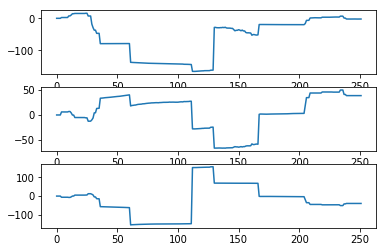

In [122]:
saver = []
savep = []
saveh = []

for r,p,h in save_angles:
    saver.append(r*180/pi)
    savep.append(p*180/pi)
    saveh.append(h*180/pi)
    
plt.subplot(3,1,1)
plt.plot(saver)
plt.subplot(3,1,2)
plt.plot(savep)
plt.subplot(3,1,3)
plt.plot(saveh)

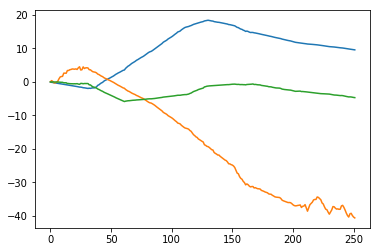

In [119]:
plt.plot(save_pts)

In [120]:
def plotGroundPath(pts):
    savex = []
    savey = []
    savez = []

    for x,y,z in pts:
        savex.append(x)
        savey.append(y)
        savez.append(z)
    
    plt.subplot(1,2,1)
    plt.plot(savey, savex)
    plt.grid(True)
    plt.title('x,y');

    # plt.subplot(1,2,2)
    # plt.plot(savez)
    # plt.grid(True)
    # plt.title('z')

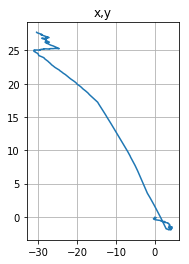

In [144]:
plotGroundPath(save_pts)

Text(0.5,1,u'next frame')

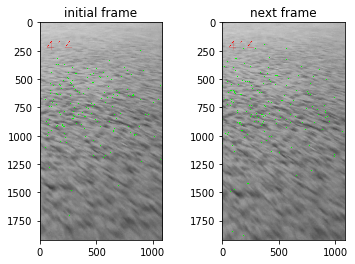

In [151]:
i = 70
old_im = buffer[i]
im = buffer[i+1]
p0 = featureDetection(old_im)
p0, p1 = featureTrack(im,old_im,p0)

plt.subplot(1,2,1)
plt.imshow(drawKeyPoints(old_im, p0))
plt.title('initial frame')

plt.subplot(1,2,2)
plt.imshow(drawKeyPoints(im, p1))
plt.title('next frame')

In [92]:
def map2D(v,u,zz):
    H = .11
    D = .2
    V = 1920 # vertical pixels
    VFOV = 75*pi/180
    aa = atan2(H,D)
    B = atan((2*v-V)*tan(VFOV/2))
    y = H/tan(aa+B)
    z = H*cos(B)/sin(aa+B)
    return (y,u,z)

In [104]:
def DCM2Eul(R):
    return (atan2(R[1,2],R[2,2]), asin(-R[0,2]), atan2(R[0,2],R[0,0]))

In [123]:
import platform
def videoWrite(frames, fname='out.mp4'):
    frame_height, frame_width, _ = frames[0].shape

    # pick a good encoder for the current OS
    sys = platform.system()
    if sys in ['Darwin']:  # this is on macOS
        fourcc = 'avc1'
    else:  # this is for Windoze
        fourcc = 'mjpg'

    out = cv2.VideoWriter(
        fname,
        cv2.VideoWriter_fourcc(*fourcc), 
        30, 
        (frame_width,frame_height))
    for frame in frames:
        out.write(frame)
    out.release()

In [145]:
videoWrite(save_im)

In [141]:
HTML('<iframe src="out.mp4" width="640" height="360" frameborder="0" webkitallowfullscreen mozallowfullscreen allowfullscreen></iframe>')

In [126]:
help(cv2.drawKeypoints)

Help on built-in function drawKeypoints:

drawKeypoints(...)
    drawKeypoints(image, keypoints, outImage[, color[, flags]]) -> outImage
    .   @brief Draws keypoints.
    .   
    .   @param image Source image.
    .   @param keypoints Keypoints from the source image.
    .   @param outImage Output image. Its content depends on the flags value defining what is drawn in the
    .   output image. See possible flags bit values below.
    .   @param color Color of keypoints.
    .   @param flags Flags setting drawing features. Possible flags bit values are defined by
    .   DrawMatchesFlags. See details above in drawMatches .
    .   
    .   @note
    .   For Python API, flags are modified as cv2.DRAW_MATCHES_FLAGS_DEFAULT,
    .   cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, cv2.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG,
    .   cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS

